In [186]:
# !conda install -c conda-forge statsmodels

import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.optimize as opt
import econtools 
import econtools.metrics as mt
import statsmodels.discrete.discrete_model as sm
from sklearn.utils import resample
import itertools as iter
import matplotlib.pyplot as plt

# mine
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import myfunctions as mf

import production.firm_production as prod
import importlib
importlib.reload(mf)
importlib.reload(prod)

<module 'production.firm_production' from '/Users/jingyuanwang/GitHub/NU450_HW/450-1-HW1/production/firm_production.py'>

In [187]:
# ------------------------------------------------------------------------
# NOTE
# ------------------------------------------------------------------------
# Purpose: HW1 P2
# 
# Inport data and stats
# Test OP and GNR model
#
# ------------------------------------------------------------------------

# 0. Initialize file path -----------------------------------------------

In [188]:
rootpath = '/Users/jingyuanwang/Dropbox/Course/ECON/IO/NU450/NU450_HW/450-1-HW1'
datapath = rootpath + '/' + 'data'
resultpath = rootpath + '/' + 'results'

# I. Import data -------------------------------------------------------

In [189]:
# 1. get data
filename = 'PS1_data_cleaned'
inputname = datapath + '/' + filename + '.dta'
df = pd.read_stata(inputname)

In [190]:
# 2. fit it into a class: panel data productivity
firm_prod = prod.firm_production(df = df, firm_id = 'firm_id', year_id = 'year', 
                                 industry_id='industry_id',
                                resultpath = resultpath)

-- Table: Number of firms in each industry-year (full sample) ----
industry_id  1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  \
year                                                                          
1990         14  36  50  61  35   9  56  26  15  15  64  16  73  13  37  39   
1991         18  60  68 102  53  10  92  43  23  22  97  23 112  29  54  71   
1992         23  75  86 124  58  11 108  52  27  25 127  28 133  37  70  86   
1993         24  74  84 112  63  12  99  56  25  28 136  30 126  36  74  84   
1994         29  85  92 119  75  11 105  59  22  35 129  25 129  35  76  85   
1995         32  86  92 123  80   9 106  59  24  40 128  25 131  32  68  86   
1996         34  91  88 125  84   9 100  59  25  41 126  23 132  41  69  92   
1997         35  91  88 163  93  14 118  70  30  44 135  19 139  50  86 103   
1998         30  88  85 160  90  12 112  67  31  39 128  18 135  46  83 101   
1999         29  71  71 137  76   9  91  58  27  27 107  15 121 

In [191]:
# get a balanced panel
firm_prod.balance_panel()

-- Table: Number of firms in each industry-year (balanced sample) ----
industry_id  1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  \
year                                                                          
1990          5  21  14  24  13   3  26  11   6   6  26   5  32   5  10  15   
1991          5  21  14  24  13   3  26  11   6   6  26   5  32   5  10  15   
1992          5  21  14  24  13   3  26  11   6   6  26   5  32   5  10  15   
1993          5  21  14  24  13   3  26  11   6   6  26   5  32   5  10  15   
1994          5  21  14  24  13   3  26  11   6   6  26   5  32   5  10  15   
1995          5  21  14  24  13   3  26  11   6   6  26   5  32   5  10  15   
1996          5  21  14  24  13   3  26  11   6   6  26   5  32   5  10  15   
1997          5  21  14  24  13   3  26  11   6   6  26   5  32   5  10  15   
1998          5  21  14  24  13   3  26  11   6   6  26   5  32   5  10  15   
1999          5  21  14  24  13   3  26  11   6   6  26   5 

# II. Stats ---------------------------------------------------------

In [192]:
# --------------------------------------
# Table 1 statistics on variables
# --------------------------------------
def sum_stats(df, tablename=None):
    list_var = ['ly','lc','lh','lm','linv']
    dict_var = {'ly':'lg(Gross Output)',
            'lc':'lg(Capital)',
            'lh':'lg(Labor)',
            'lm':'lg(Materials)',
            'linv':'lg(Investment)',}
    pd.options.display.float_format = '{:.2f}'.format

    table  = (df[list_var].describe().T
             .reindex(list_var)
             .rename(columns={'count':'N'}, index=dict_var)
             )
    
    if tablename != None:
        outputname = resultpath + '/' + tablename + '.tex'
        table.to_latex(outputname)
    return table
    
sum_stats(firm_prod.full_sample, 'Table1_fullsample')
sum_stats(firm_prod.balanced_sample, 'Table1_balancedsample')

,N,mean,std,min,25%,50%,75%,max
lg(Gross Output),2350.00,14.04,1.64,8.86,12.57,14.10,15.36,18.05
lg(Capital),2350.00,12.32,1.87,8.02,10.84,12.23,13.86,17.56
lg(Labor),2350.00,7.48,0.06,6.38,7.47,7.49,7.50,7.80
lg(Materials),2350.00,13.49,1.76,6.84,12.06,13.59,14.87,17.78
lg(Investment),2350.00,9.43,3.77,0.00,8.47,10.27,11.90,15.96


In [202]:
# --------------------------------------
# Table 2: number of firms per industry 
#          number of firms with invest/labor/material ==0
# --------------------------------------
def table2(df, tablename=None):
    pd.options.display.float_format = '{:,.0f}'.format
    table2 = (df.pivot_table(values=['firm_id','lh','linv','lm'], 
                    index=['industry_id', 'year'], 
                    aggfunc={'firm_id':np.count_nonzero, 
                             'lh':np.count_nonzero,
                             'linv': np.count_nonzero,
                             'lm':np.count_nonzero}  )
          .rename(columns = {'firm_id': 'Number of firms',
                             'lh' : 'Labor input = 0',
                             'linv' : 'Investment = 0',
                             'lm' : 'Materials input = 0'} )
         )
    for columnName in table2.columns[1:]:
        table2[columnName] = table2['Number of firms'] - table2[columnName] 
        
    table2_N = table2.reset_index().pivot(index='year', columns='industry_id', values='Number of firms')
    table2_inv = table2.reset_index().pivot(index='year', columns='industry_id', values='Investment = 0')
    table2_l = table2.reset_index().pivot(index='year', columns='industry_id', values='Labor input = 0')
    table2_m = table2.reset_index().pivot(index='year', columns='industry_id', values='Materials input = 0')
    
    if tablename != None:
        outputname = resultpath + '/' + tablename + '_numoffirm' + '.tex'
        table2_N.to_latex(outputname)
        outputname = resultpath + '/' + tablename + '_invest' + '.tex'
        table2_inv.to_latex(outputname)
        outputname = resultpath + '/' + tablename + '_material' + '.tex'
        table2_l.to_latex(outputname)
        outputname = resultpath + '/' + tablename + '_labor' + '.tex'
        table2_m.to_latex(outputname)
    
    return table2_N, table2_inv, table2_l, table2_m

(table2_N, table2_inv, table2_l, table2_m)=table2(firm_prod.balanced_sample, 'Table2_balancedsample')
(table2_N, table2_inv, table2_l, table2_m)=table2(firm_prod.full_sample, 'Table2_fullsample')
pd.options.display.float_format = '{:,.5f}'.format

# III. regression ---------------------------------------------------------

## OP

In [203]:
# specify variable names, in ln
yvar = 'ly_va'
statevar = 'lc'
labor = 'll'
investment = 'linv'
exit = 'exit'
ids = ['industry_id', 'firm_id', 'year']

In [204]:
# what goes into the OP model
industry = 13
variables = [yvar, statevar, labor,investment, exit]

In [205]:
# STEP 0 : get data, generate non-par polynomials
df = firm_prod.full_sample.loc[firm_prod.full_sample['industry_id']==industry, ids + variables]
[df, poly] = mf.gen_poly(df,['linv','lc'],3)

-- generate: poly_linv_lc_0_0 --
-- generate: poly_linv_lc_1_0 --
-- generate: poly_linv_lc_2_0 --
-- generate: poly_linv_lc_3_0 --
-- generate: poly_linv_lc_0_1 --
-- generate: poly_linv_lc_0_2 --
-- generate: poly_linv_lc_0_3 --
-- ['linv', 'lc']
-- generate: poly_linv_lc_1_1 --
-- ['linv', 'lc']
-- generate: poly_linv_lc_1_2 --
-- generate: poly_linv_lc_2_1 --
# --- Finish generating polynomials ---


In [206]:
# step 1: single out flexible var and state var 
# get a function of all state vars Phi --> able to express unknown state var (productivity) by known state vars

# (1) OLS
xvar = poly + [labor]
stage1 = mt.reg(df, yvar, xvar)

In [208]:
# (2) get labor coeff
beta_l = stage1.beta[labor]
# save yhat and phi, where yhat = betal * l + phi
df['yhat'] = stage1.yhat
df['phi'] = stage1.yhat - beta_l*df[labor]

In [210]:
# step 2: estimate an "correlated" exit rate --> how exit rate depends on known state variables
# logit
# (1) regression
model = sm.Probit(df[exit].values, df.groupby('firm_id')[poly].shift(periods = 1).values,missing='drop')
results = model.fit(maxiter=10000)

Optimization terminated successfully.
         Current function value: 0.259200
         Iterations 8


In [211]:
# (2) save p_hat
p_hat = model.cdf(results.fittedvalues)

# merge
df2 = df[ids]
df2['p_hat'] = df.groupby('firm_id')['poly_linv_lc_0_0'].shift(periods = 1)
df2 = df2[~np.isnan(df2['p_hat'])]
df2['p_hat'] = p_hat

df = pd.merge(df, df2, how = 'left',
        left_on = ids, right_on = ids)

/Users/jingyuanwang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [212]:
# step 3: regress the function of state vars Phi on certain format of state var --> to identify coeffs
# for the unknown statevar, replace with a control function got from step 1

df['L_lncapital'] = df.groupby('firm_id')['lc'].shift(periods = 1)
df['L_phi'] = df.groupby('firm_id')['phi'].shift(periods = 1)

# clean df
# drop a row if any element == nan
df.dropna(inplace = True)


In [215]:
poly_max = 3

# Optimize
def g(beta0, beta_k, gammas, df):
    L_omega = (df['L_phi'] - beta0 - beta_k * df['L_lncapital']).values
    p_hat = df['p_hat'].values
    
    # generate polynomials
    d = {'L_omega': L_omega, 'p_hat':p_hat}
    df_temp = pd.DataFrame(data=d)
    [df_temp, poly]=mf.gen_poly(df_temp, ['L_omega', 'p_hat'], poly_max = poly_max, print_output=False)
    poly.remove('poly_L_omega_p_hat_0_0')
    
    a_vector_of_fitted = df_temp[poly].values@gammas[0:len(poly)]
    return a_vector_of_fitted

def OP_stage2_obj(beta, df):
    ''' the LHS is phi'''
    beta0 = beta[0]
    beta_k = beta[1]
    gammas = beta[2:]
    LHS = df['phi']
    RHS = beta0+beta_k*df['lc'].values+g(beta0, beta_k, gammas, df)
    return sum((LHS-RHS)**2)
    

beta_initial = np.zeros(2)
gammas_initial = np.zeros(50)  # 50 is just a sufficient long number
initial = np.append(beta_initial, gammas_initial )
results = opt.minimize(OP_stage2_obj,
                       initial,
                       args = (df) )

In [216]:
alphas_OP = {'alpha_k':results.x[1], 
             'alpha_l':beta_l}
alphas_OP

{'alpha_k': 0.4796355413113163, 'alpha_l': 0.7806972701566224}

## GNR

In [217]:
# specify variable names, in ln
yvar = 'ly'
statevar = ['lc','ll']
flexiblevar = 'lm'
price_m = 'lwm'
price_y = 'lp'
prices = [price_m, price_y]
ids = ['industry_id', 'firm_id', 'year']

--GNR:
--for industry 9 ----------------------
-- generate: poly_lc_ll_lm_0_0_0 --
-- generate: poly_lc_ll_lm_1_0_0 --
-- generate: poly_lc_ll_lm_2_0_0 --
-- generate: poly_lc_ll_lm_0_1_0 --
-- generate: poly_lc_ll_lm_0_2_0 --
-- generate: poly_lc_ll_lm_0_0_1 --
-- generate: poly_lc_ll_lm_0_0_2 --
-- ['lc', 'll']
-- generate: poly_lc_ll_1_1 --
-- ['lc', 'lm']
-- generate: poly_lc_lm_1_1 --
-- ['ll', 'lm']
-- generate: poly_ll_lm_1_1 --
-- ['lc', 'll', 'lm']
# --- Finish generating polynomials ---
--GNR: stage 1 optimization completed


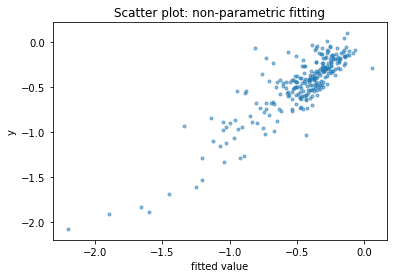

['poly_lc_ll_lm_0_0_0', 'poly_lc_ll_lm_1_0_0', 'poly_lc_ll_lm_2_0_0', 'poly_lc_ll_lm_0_1_0', 'poly_lc_ll_lm_0_2_0', 'poly_lc_ll_lm_0_0_1', 'poly_lc_ll_lm_0_0_2', 'poly_lc_ll_1_1', 'poly_lc_lm_1_1', 'poly_ll_lm_1_1']
--GNR: stage 1 completed --------------------- 
-- generate: poly_ll_lc_0_0 --
-- generate: poly_ll_lc_1_0 --
-- generate: poly_ll_lc_0_1 --
# --- Finish generating polynomials ---
--GNR: stage 2 optimization completed


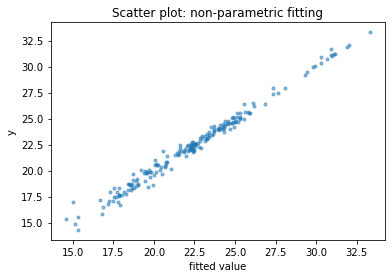

['poly_ll_lc_0_0', 'poly_ll_lc_1_0', 'poly_ll_lc_0_1']
--GNR: stage 2 completed ---------------------

--GNR: fitted ln(gross output) (single out productivities)


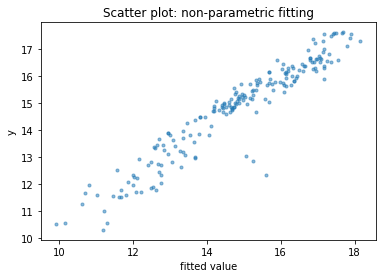

# --- ~ o(*￣▽￣*)o ~
# --- Complete GNR !!!  ~ o(*￣▽￣*)o ~


In [232]:
sample = firm_prod.full_sample
[alphas_final,df_stage1,df_stage2, parameters] = firm_prod.GNR(sample, yvar, statevar, flexiblevar,price_m, price_y, 
                                                               industry=9, 
                                                               stage1_polymax=2,
                                                               stage2_polymax=1)
# stage1_polymax <= 2
# stage2_polymax <= 3
# Because I haven't code a general integration function for polynomials. 
# Just mannually type integral for poly<=2 in stage 1, and poly<=3 in stage 2

# Works for most industries! Super good ones: industry 13, industry 9
# For industry 1, stage1 fit is bad so it does not work. 
# The solution should be increase stage1_polymax > 2,  but I am lazy, do not want to write the integral function...

# Interpret the graphs:
# graph1: fitting for stage1
# graph2: fitting for stage2
# graph3: fitting for stage1 results + stage 2 (first part in the equation). 
#         This should be the production function, without omega. I plot this with the gross output: ly

# Potential problem and how to solve:
# Some times graph 1 and 2 fits perfectly, but graph3 are way off. 
#         This might caused by the over fitting problem in stage 2. 
#         Notice that in the stage 2 equation, the RHS is like: beta*X - g(beta*X_{t-1})
#         GrossOutput = stage1 + beta*X
#         I suspect if X and X_{t-1} are highly correlated, and when we include too much poly:
#                 even the first part of stage2, beta*X, is not correct,
#                 this incorrectness "cancels out" in stage2 fitting because RHS is beta*X - g(beta*X_{t-1})
#                 And this problem shows up when we do GrossOutput = stage1 + beta*X. Because this incorrectness won't cancel here.
#        I think this is just caused by overfitting. 
#    Solution: include less polynomials in stage2, you should be able to see an almost perfect graph3


In [233]:
alphas_final

{'alpha_k': 0.3142835936647192,
 'alpha_l': 0.26803272275372186,
 'alpha_m': 0.6477870029258606}

# Bootstrap-GNR SE

In [234]:
def bootstrap(df, groupid, estimation ,total_times = 10):
    beta_all = []
    
    # draw from firm index pool
    index = df[groupid].unique()
    # num of firms
    subsample_num_of_firms = np.ceil(len(index)*0.8).astype(int)
    
    for n in range(0,total_times):
        # resample
        sample_firms = resample(index, replace = True, n_samples=subsample_num_of_firms)
        subsample = df[df[groupid].isin(sample_firms)]
        # estimation
        results = estimation(subsample)
        betas = results[0]
        betas = np.fromiter(betas.values(), dtype=float)
        # save beta
        if np.isnan(betas).any()==False:
            beta_all.append(betas)
        # print progress every 10 optimizations
        if n%20 == 0:
            print('--{}------'.format(n))
            print('beta: {}'.format(betas))
            
    # get variance of beta
    b = np.column_stack(beta_all)
    var_cov = np.cov(b)
    std_err = np.sqrt(np.diag(var_cov))
    return [std_err, var_cov]

In [235]:
sample = firm_prod.full_sample[firm_prod.full_sample['industry_id'] == 13]
estimation = lambda x: firm_prod.GNR(x, yvar, statevar, 
                                     flexiblevar,price_m, price_y, 
                                    stage2_polymax=1,
                                    print_output = False)
[std_err, var_cov] = bootstrap(sample,'firm_id', estimation, total_times=50)

--0------
beta: [0.15756613 0.31532795 0.57154386]
--20------
beta: [0.20810984 0.25758724 0.54578619]
--40------
beta: [0.12623187 0.3205169  0.57829795]


In [236]:
std_err

array([0.06046542, 0.21103386, 0.01773799])